In [13]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

In [14]:
#Input file
rmg_model_path = '../ammonia/'
analysis_path = '../ammonia_analysis/O2_results'

In [15]:
#Git-python: checkout master branch
import git
repo = git.Repo(rmg_model_path)
date = time.localtime(repo.head.commit.committed_date)
git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")

current_commit = f"{git_date}_{git_sha}_{git_msg}"

current_commit

'2021_6_5_1819_463449_master_523K_O088N006'

In [18]:
# #checkout 1 commit back
# repo.git.checkout('HEAD^1')
# sha = str(repo.head.commit)
# msg = str(repo.head.commit.message)
# print(sha,': ', msg)

# #checkout 2 commit back
# repo = git.Repo('/work/westgroup/lee.ting/cantera/ammonia/')
# repo.git.checkout('HEAD^1')
# sha = repo.head.commit
# msg = repo.head.commit.message
# print(sha,': ', msg)

In [16]:
commit_list = []

# read in each filename into dictionary. get a list of the commit folders in this repo
for path in Path(analysis_path).rglob('*.csv'):
    path_str = str(path)
    start_index = path_str.find(analysis_path)
    
    if start_index != -1:
        commit = path_str[(start_index+len(analysis_path)):]
        print(commit)
        if "\n" in commit:
            end_char = commit.index("\n")
        else: 
            end_char = commit.index("/")
        
        commit = commit[:end_char]
        if commit not in commit_list:
            commit_list.append(commit)
        
print(commit_list)   

/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_018787878787878787_NH3_0.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_027575757575757573_NH3_0.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_03636363636363636_NH3_0.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_04515151515151515_NH3_0.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_05393939393939394_NH3_0.csv
/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinnin

/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_018787878787878787_NH3_0.csv
/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_027575757575757573_NH3_0.csv
/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_03636363636363636_NH3_0.csv
/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_04515151515151515_NH3_0.csv
/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_05393939393939394_NH3_0.csv
/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/S

In [17]:
data_dict = {}

# Read last line from each CSV file to get the outlet concentrations from the PFR
# if "one_commit" is true, only run the master commit 
one_commit = False
if one_commit == True:
    commit_list = [current_commit]
    
for commit in commit_list:
    first_file = True
    for path in Path('../ammonia_analysis/O2_results').rglob('*.csv'):
        path_str = str(path)
        if os.stat(path_str).st_size >= 1e6:
            if first_file == True: 
                data = pd.read_csv(path_str)
                aggdata = data.tail(1)
                first_file = False
            else: 
                data = pd.read_csv(path_str)
                aggdata = aggdata.append(data.tail(1))
            data_dict.update({commit:aggdata})
        else:
            print(path_str)

../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_018787878787878787_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_027575757575757573_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_03636363636363636_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_04515151515151515_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy

../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_43181818181818177_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_44060606060606056_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_44939393939393935_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_45818181818181813_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_o

../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_8272727272727273_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_8360606060606061_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_8448484848484848_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_8536363636363635_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_5_1819_463449_master_523K_O088N006/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_t

../ammonia_analysis/O2_results/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_6778787878787879_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_6954545454545454_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_7921212121212121_NH3_0.csv
../ammonia_analysis/O2_results/2021_6_8_2326_792175_master_673K_O088N0066/IdealGasReactor/energy_off/sensitivity_off/5/results/Spinning_basket_area_1.11e-07_energy_off_temp_598_O2_0_8272727272727273_NH3_0.csv


## Reproduce plots from Rebrov

Rebrov, E. V., De Croon, M. H. J. M., & Schouten, J. C. (2002). Development of the kinetic model of platinum catalyzed ammonia oxidation in a microreactor. Chemical Engineering Journal, 90(1–2), 61–76. https://doi.org/10.1016/S1385-8947(02)00068-2


for reference: 

### $conversion(\%) = \frac{moles\_fed - moles\_out}{moles\_fed} $

### $selectivity(\%, N_2) = \frac{(2*r_{L6}+r_{L13})100}{r_{L5}} $

### $selectivity(\%, N_{2}O) = \frac{(2*r_{L7}-r_{L13})100}{r_{L5}} $

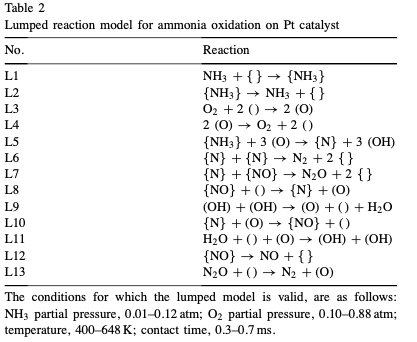

In [21]:
Image('Images/Rebrov_table2.png')

### Figure 3

### create partial pressure, selectivity, and concentration columns in the dataframe

In [18]:
#choose species partial pressures (for X-axis of plots) 
x_axis_o2 = ['X_o2 initial']

conversion_species = ['NH3(6)']
selectivity_species = ['N2(4)','N2O(7)','NO(5)']
# this is H-site adsorption. no way to tell that from cantera 
coverage_species_1 = ['OX(10)', 'HOX(13)', 'X(1)'] 

# this is N-site adsorption. no way to tell that from cantera
#coverage_species_2 = ['NOX(27)', 'NX(59)', 'H3NX(29)', 'X(1)']
coverage_species_2 = ['NO_ads(27)', 'N_ads(64)', 'H3NX(29)', 'X(1)']

In [19]:
for commit in commit_list:
    for i in conversion_species:
        data_dict[commit]['NH3(6) conversion (%)'] = 100*(data_dict[commit]['X_nh3 initial'] - data_dict[commit][i])/data_dict[commit]['X_nh3 initial']
    
    for i in selectivity_species:
        data_dict[commit][f'{i} Selectivity (%)'] = 100*(data_dict[commit][i])/(data_dict[commit]['X_nh3 initial'] - data_dict[commit]['NH3(6)'])

    for i in coverage_species_1:
        data_dict[commit][f'{i} Coverage'] = (data_dict[commit][i])/(data_dict[commit]['OX(10)'] + data_dict[commit]['HOX(13)']+ data_dict[commit]['X(1)'])
    
    for i in coverage_species_2:
        data_dict[commit][f'{i} Coverage'] = (data_dict[commit][i])/(data_dict[commit]['NO_ads(27)'] + data_dict[commit]['N_ads(64)']+ data_dict[commit]['H3NX(29)']+ data_dict[commit]['X(1)'])
         

In [20]:
data_dict[commit].to_csv("rebrov_O2_data.csv")
data_dict[commit]

,Distance (mm),T (K),P (Pa),V (M^3/s),X_nh3 initial,X_o2 initial,X_he initial,(NH3/O2),T (K) final,Rtol,...,NH3(6) conversion (%),N2(4) Selectivity (%),N2O(7) Selectivity (%),NO(5) Selectivity (%),OX(10) Coverage,HOX(13) Coverage,X(1) Coverage,NO_ads(27) Coverage,N_ads(64) Coverage,H3NX(29) Coverage
1000,9.0,598,101324.988677,2.771000e-08,0.066,0.107879,0.826121,0.611798,598.0,1.000000e-11,...,96.858269,49.190716,0.000000e+00,7.842082e-08,0.998047,6.318705e-09,0.088751,0.911170,0.000062,0.000017
1000,9.0,598,101324.990504,2.771000e-08,0.066,0.115758,0.818242,0.570157,598.0,1.000000e-11,...,95.475636,49.193276,0.000000e+00,7.847788e-08,0.997562,7.258554e-09,0.090830,0.909077,0.000067,0.000025
1000,9.0,598,101325.000000,2.771000e-08,0.066,0.123636,0.810364,0.533824,598.0,1.000000e-11,...,95.261336,49.195603,0.000000e+00,8.545340e-08,0.997714,7.061910e-09,0.081737,0.918175,0.000064,0.000024
1000,9.0,598,101325.000000,2.771000e-08,0.066,0.131515,0.802485,0.501843,598.0,1.000000e-11,...,95.579112,49.197620,0.000000e+00,9.568816e-08,0.998055,6.478931e-09,0.070704,0.929219,0.000058,0.000019
1000,9.0,598,101324.947229,2.771000e-08,0.066,0.139394,0.794606,0.473478,598.0,1.000000e-11,...,94.901900,49.199585,0.000000e+00,9.942487e-08,0.997963,6.718615e-09,0.067880,0.932040,0.000059,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,9.0,598,101324.948336,2.771000e-08,0.066,0.844848,0.089152,0.078121,598.0,1.000000e-11,...,0.000004,9.352920,-1.940627e-29,8.105068e+01,0.999999,3.993392e-12,NaN,NaN,NaN,NaN
1000,9.0,598,101322.893207,2.771000e-08,0.066,0.853636,0.080364,0.077316,598.0,1.000000e-11,...,0.000005,9.141568,5.542335e-29,8.063986e+01,0.999999,3.961878e-12,NaN,NaN,NaN,NaN
1000,9.0,598,101325.000000,2.771000e-08,0.066,0.862424,0.071576,0.076528,598.0,1.000000e-11,...,0.000003,8.787889,2.229526e-30,8.171683e+01,0.999999,3.945032e-12,NaN,NaN,NaN,NaN
1000,9.0,598,101323.828062,2.771000e-08,0.066,0.871212,0.062788,0.075757,598.0,1.000000e-11,...,0.000005,8.812095,2.172946e-29,8.195078e+01,0.999999,3.907795e-12,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='X_o2 initial', ylabel='NH3(6) conversion (%)'>

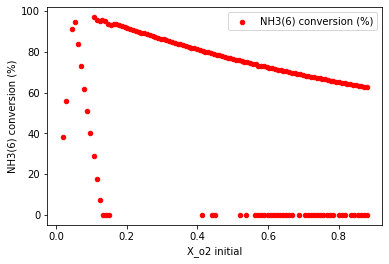

In [21]:
data_dict[commit].plot.scatter(x='X_o2 initial',y='NH3(6) conversion (%)',label='NH3(6) conversion (%)',color="r")

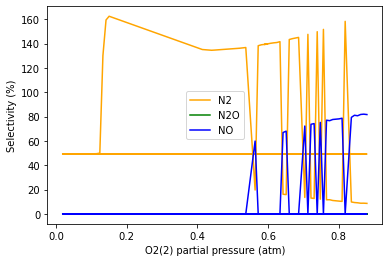

In [22]:
ax1 = data_dict[commit].plot(x='X_o2 initial',y='N2(4) Selectivity (%)',
                                     label='N2',color="orange")
ax2 = data_dict[commit].plot(x='X_o2 initial',y='N2O(7) Selectivity (%)',
                                     label='N2O',color='g', ax=ax1)
ax3 = data_dict[commit].plot(x='X_o2 initial',y='NO(5) Selectivity (%)',
                                     label='NO',color='blue', ax=ax1)
ax1.set_xlabel("O2(2) partial pressure (atm)")
ax1.set_ylabel("Selectivity (%)")
plt.show()

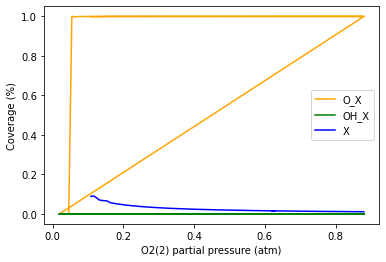

In [23]:
ax1 = data_dict[commit].plot(x='X_o2 initial',y='OX(10) Coverage',
                                     label='O_X',color="orange")
ax2 = data_dict[commit].plot(x='X_o2 initial',y='HOX(13) Coverage',
                                     label='OH_X',color='g', ax=ax1)
ax3 = data_dict[commit].plot(x='X_o2 initial',y='X(1) Coverage',
                                     label='X',color='blue', ax=ax1)
ax1.set_xlabel("O2(2) partial pressure (atm)")
ax1.set_ylabel("Coverage (%)")
plt.show()

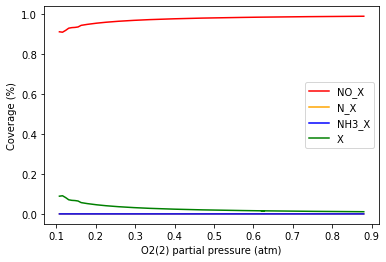

In [24]:
ax1 = data_dict[commit].plot(x='X_o2 initial',y='NO_ads(27) Coverage',
                                     label='NO_X',color="r")
ax2 = data_dict[commit].plot(x='X_o2 initial',y='N_ads(64) Coverage',
                                     label='N_X',color='orange', ax=ax1)
ax3 = data_dict[commit].plot(x='X_o2 initial',y='H3NX(29) Coverage',
                                     label='NH3_X',color='b', ax=ax1)
ax4 = data_dict[commit].plot(x='X_o2 initial',y='X(1) Coverage',
                                     label='X',color='g', ax=ax1)
ax1.set_xlabel("O2(2) partial pressure (atm)")
ax1.set_ylabel("Coverage (%)")
plt.show()

In [ ]:
for i in x_axis_o2:
    temps = data_dict[commit_list[0]]['T (K)'].unique()
#print(temps)
for commit in commit_list:
        # get keys for O2 (X_o2 initial)
        o2_ratio = data_dict[commit_list[0]]['X_o2 initial'].unique()

        # set figure size 
        fig, ax = plt.subplots(len(o2_ratio),1,figsize=(10,30), constrained_layout = True)

        # make a list of markers
        color_dict = { 0:"r", 1:"gold", 2:"pink", 3:"yellowgreen",4:"lightskyblue"}
    
        for p,j in enumerate(o2_ratio):
            data_dict[commit][data_dict[commit]['X_o2 initial'] == j].plot.scatter(x='X_nh3 initial', 
                                                                                 y='NH3(6) conversion (%)', 
                                                                                 label='NH3(6) conversion (%)', 
                                                                                 ax=ax[p], 
                                                                                 color="r")

            ax[p].set_title(f'{commit} \nmole frac O2 = {j}')
            

In [31]:
df_t_225_02_0_88_data_dict=data_dict[commit][(data_dict[commit]['X_nh3 initial'] == 0.066) &
                             (data_dict[commit]['T (K)'] == 598)]

In [32]:
df_t_225_02_0_88_data_dict

,Distance (mm),T (K),P (Pa),V (M^3/s),X_nh3 initial,X_o2 initial,X_he initial,(NH3/O2),T (K) final,Rtol,...,NH3(6) conversion (%),N2(4) Selectivity (%),N2O(7) Selectivity (%),NO(5) Selectivity (%),OX(10) Coverage,HOX(13) Coverage,X(1) Coverage,NO_ads(27) Coverage,N_ads(64) Coverage,H3NX(29) Coverage
1000,9.0,598,101324.988677,2.771000e-08,0.066,0.107879,0.826121,0.611798,598.0,1.000000e-11,...,96.858269,49.190716,0.000000e+00,7.842082e-08,0.998047,6.318705e-09,0.088751,0.911170,0.000062,0.000017
1000,9.0,598,101324.990504,2.771000e-08,0.066,0.115758,0.818242,0.570157,598.0,1.000000e-11,...,95.475636,49.193276,0.000000e+00,7.847788e-08,0.997562,7.258554e-09,0.090830,0.909077,0.000067,0.000025
1000,9.0,598,101325.000000,2.771000e-08,0.066,0.123636,0.810364,0.533824,598.0,1.000000e-11,...,95.261336,49.195603,0.000000e+00,8.545340e-08,0.997714,7.061910e-09,0.081737,0.918175,0.000064,0.000024
1000,9.0,598,101325.000000,2.771000e-08,0.066,0.131515,0.802485,0.501843,598.0,1.000000e-11,...,95.579112,49.197620,0.000000e+00,9.568816e-08,0.998055,6.478931e-09,0.070704,0.929219,0.000058,0.000019
1000,9.0,598,101324.947229,2.771000e-08,0.066,0.139394,0.794606,0.473478,598.0,1.000000e-11,...,94.901900,49.199585,0.000000e+00,9.942487e-08,0.997963,6.718615e-09,0.067880,0.932040,0.000059,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,9.0,598,101325.000000,2.771000e-08,0.066,0.836061,0.097939,0.078942,598.0,1.000000e-11,...,0.000005,9.815313,8.049971e-29,7.931194e+01,0.999999,4.014532e-12,NaN,NaN,NaN,NaN
1000,9.0,598,101324.948336,2.771000e-08,0.066,0.844848,0.089152,0.078121,598.0,1.000000e-11,...,0.000004,9.352920,-1.940627e-29,8.105068e+01,0.999999,3.993392e-12,NaN,NaN,NaN,NaN
1000,9.0,598,101325.000000,2.771000e-08,0.066,0.862424,0.071576,0.076528,598.0,1.000000e-11,...,0.000003,8.787889,2.229526e-30,8.171683e+01,0.999999,3.945032e-12,NaN,NaN,NaN,NaN
1000,9.0,598,101323.828062,2.771000e-08,0.066,0.871212,0.062788,0.075757,598.0,1.000000e-11,...,0.000005,8.812095,2.172946e-29,8.195078e+01,0.999999,3.907795e-12,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='X_o2 initial', ylabel='NH3(6) conversion (%)'>

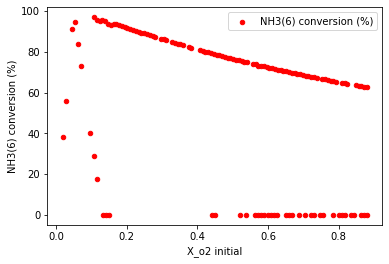

In [35]:
df_t_225_02_0_88_data_dict.plot.scatter(x='X_o2 initial', 
                                        y='NH3(6) conversion (%)', 
                                        label='NH3(6) conversion (%)', 
                                        color="r")

In [34]:
number_of_reactors = 1001
rradius = 1.4e-4 #140µm to 0.00014m
rlength = 9e-3 #9mm to 0.009m
rtotal_vol = (rradius ** 2) * np.pi * rlength / 2
rtotal_vol

2.770884720466197e-10